# ML Discrete event generation

## Setup 

In [62]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

from script import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
DATA_PATH = '../data/405.txt'
OUTPUT_PATH = '../data/predictions.csv'

cols_map = {
    "DTS": "crossTime",
    #"LANE": "lane",
    #"DIR": "direction",
    "SPEED": "speed",
    # "AX": "nAxles",
    "GW_TOT": "weight",
    # "TYPE": "type",
}

data = pd.read_csv(DATA_PATH, usecols=cols_map.keys())
data.rename(columns=cols_map, inplace=True)
# Parse crossTime column as datetime object
data.crossTime = pd.to_datetime(data.crossTime+'0000', format='%Y-%m-%d %H:%M:%S.%f')
data.head(2)

,crossTime,speed,weight
0,2011-04-01 00:41:31.400,106,15980
1,2011-04-01 00:42:10.500,116,3630


## Data preparation 

### Data truncation

In [3]:
# Truncate data to ignore COVID pandemic 
start_of_covid = "2019-10-21"
data = data.set_index('crossTime')         \
           .sort_index()                   \
           .truncate(after=start_of_covid) \
           .reset_index()

### Duplicate handling

In [4]:
def untangle_duplicated(group):
    """Adds 0ms to the crossTime of the first item, 1ms to the second, ..."""
    ms = group.speed.rank(method='first').values.astype('timedelta64[ms]') - 1
    group['crossTime']  = group.crossTime + ms
    
    return group

untangled = data[data.duplicated(subset='crossTime', keep=False)] \
             .groupby('crossTime')                                \
             .apply(untangle_duplicated)

data.loc[untangled.index] = untangled

In [5]:
print(f"The crossing times are now unique: {data.crossTime.is_unique}")
data.head()

The crossing times are now unique: True


,crossTime,speed,weight
0,2011-04-01 00:41:31.400,106,15980
1,2011-04-01 00:42:10.500,116,3630
2,2011-04-01 00:47:15.700,84,18480
3,2011-04-01 01:23:37.200,88,11050
4,2011-04-01 01:33:23.400,89,30330


### Output data

We wish to transform our dataset into the following: 
* Each row represents an hour
* Column $i$ is the time at which the $i$-th vehicle of the hour passed over the sensor. 
* If $i$ is bigger than the number of the vehicles that hour, then the value at column $i$ is $-1$

#### Add timestamps

We first add the `hour_timestamp` column, which is the crossing time trunctated to the hour. We also add the `frac_of_hour` column, which is the fraction of the hour of the crossing time.

I.e. `2012-09-01 13:15:00` becomes `2012-09-01 13:00:00` and $0.25$ respectively.

In [6]:
sub_hours = data.crossTime.values - data.crossTime.values.astype('datetime64[h]')
data['hour_timestamp'] = data.crossTime.values.astype('datetime64[h]')
data['frac_of_hour'] = sub_hours / np.timedelta64(1, 'h')

data.head()

,crossTime,speed,weight,hour_timestamp,frac_of_hour
0,2011-04-01 00:41:31.400,106,15980,2011-04-01 00:00:00,0.692056
1,2011-04-01 00:42:10.500,116,3630,2011-04-01 00:00:00,0.702917
2,2011-04-01 00:47:15.700,84,18480,2011-04-01 00:00:00,0.787694
3,2011-04-01 01:23:37.200,88,11050,2011-04-01 01:00:00,0.393667
4,2011-04-01 01:33:23.400,89,30330,2011-04-01 01:00:00,0.556500


We then add the `nth_in_hour` column, which is the position of the row in the hour ($i$).

In [214]:
data['nth_in_hour'] = data[['frac_of_hour', 'hour_timestamp']] \
                            .groupby('hour_timestamp') \
                            .rank().astype(int)

data.head(10)

,crossTime,speed,weight,hour_timestamp,frac_of_hour,nth_in_hour
0,2011-04-01 00:41:31.400,106,15980,2011-04-01 00:00:00,0.692056,1
1,2011-04-01 00:42:10.500,116,3630,2011-04-01 00:00:00,0.702917,2
2,2011-04-01 00:47:15.700,84,18480,2011-04-01 00:00:00,0.787694,3
3,2011-04-01 01:23:37.200,88,11050,2011-04-01 01:00:00,0.393667,1
4,2011-04-01 01:33:23.400,89,30330,2011-04-01 01:00:00,0.556500,2
5,2011-04-01 01:48:48.300,89,18880,2011-04-01 01:00:00,0.813417,3
6,2011-04-01 01:55:39.700,86,18330,2011-04-01 01:00:00,0.927694,4
7,2011-04-01 01:57:07.600,86,16620,2011-04-01 01:00:00,0.952111,5
8,2011-04-01 01:59:55.200,102,12660,2011-04-01 01:00:00,0.998667,6
9,2011-04-01 02:04:49.200,84,22560,2011-04-01 02:00:00,0.080333,1


We pivot on `hour_timestamp` to obtain out desired output

#### Generate one column per crossing 

In [215]:
cross_times = data.pivot_table(index='hour_timestamp', columns='nth_in_hour', 
                           values='frac_of_hour', fill_value=-1)
cross_times.head()

nth_in_hour,1,2,3,4,5,6,7,8,9,10,...,387,388,389,390,391,392,393,394,395,396
hour_timestamp,,,,,,,,,,,,,,,,,,,,,
2011-04-01 00:00:00,0.692056,0.702917,0.787694,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000,-1.000,-1.000000,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2011-04-01 01:00:00,0.393667,0.556500,0.813417,0.927694,0.952111,0.998667,-1.000000,-1.00000,-1.000,-1.000000,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2011-04-01 02:00:00,0.080333,0.144056,0.993944,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000,-1.000,-1.000000,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2011-04-01 03:00:00,0.144472,0.421694,0.651250,0.973194,-1.000000,-1.000000,-1.000000,-1.00000,-1.000,-1.000000,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2011-04-01 04:00:00,0.029028,0.160778,0.302917,0.350417,0.368806,0.389611,0.421472,0.46575,0.572,0.748806,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


We reindex to add hours with no cars

In [216]:
mn, mx = cross_times.index.min(), cross_times.index.max()
date_index = pd.date_range(mn, mx, freq='H') 

cross_times = cross_times.reindex(date_index, fill_value=-1.0)
cross_times

nth_in_hour,1,2,3,4,5,6,7,8,9,10,...,387,388,389,390,391,392,393,394,395,396
2011-04-01 00:00:00,0.692056,0.702917,0.787694,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2011-04-01 01:00:00,0.393667,0.556500,0.813417,0.927694,0.952111,0.998667,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2011-04-01 02:00:00,0.080333,0.144056,0.993944,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2011-04-01 03:00:00,0.144472,0.421694,0.651250,0.973194,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2011-04-01 04:00:00,0.029028,0.160778,0.302917,0.350417,0.368806,0.389611,0.421472,0.465750,0.572000,0.748806,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-10-20 19:00:00,0.056528,0.071167,0.142167,0.168111,0.172389,0.340444,0.340972,0.345722,0.479361,0.493278,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2019-10-20 20:00:00,0.022278,0.031389,0.033583,0.057250,0.118306,0.162028,0.168917,0.260417,0.293528,0.324306,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2019-10-20 21:00:00,0.023472,0.071833,0.081222,0.237806,0.308278,0.314889,0.361083,0.392611,0.393222,0.401889,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2019-10-20 22:00:00,0.047944,0.156250,0.230722,0.304278,0.378194,0.425194,0.551028,0.589778,0.699972,0.791111,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


#### Normalization and splitting

In [217]:
train_out, val_out, test_out, train_out_mean, train_out_std = split_norm_data(cross_times, return_mean_std=True, 
                                                                              splitter=year_splitter, mean_std_scalars=True)

In [218]:
print(f"Training output: {train_out.shape}")
train_out.head()

Training output: (40056, 396)


nth_in_hour,1,2,3,4,5,6,7,8,9,10,...,387,388,389,390,391,392,393,394,395,396
2011-04-01 00:00:00,3.114848,3.137104,3.310831,-0.352526,-0.352526,-0.352526,-0.352526,-0.352526,-0.352526,-0.352526,...,-0.352526,-0.352526,-0.352526,-0.352526,-0.352526,-0.352526,-0.352526,-0.352526,-0.352526,-0.352526
2011-04-01 01:00:00,2.503387,2.837066,3.363542,3.597721,3.647755,3.743157,-0.352526,-0.352526,-0.352526,-0.352526,...,-0.352526,-0.352526,-0.352526,-0.352526,-0.352526,-0.352526,-0.352526,-0.352526,-0.352526,-0.352526
2011-04-01 02:00:00,1.861302,1.991882,3.733481,-0.352526,-0.352526,-0.352526,-0.352526,-0.352526,-0.352526,-0.352526,...,-0.352526,-0.352526,-0.352526,-0.352526,-0.352526,-0.352526,-0.352526,-0.352526,-0.352526,-0.352526
2011-04-01 03:00:00,1.992736,2.560821,3.031228,3.690960,-0.352526,-0.352526,-0.352526,-0.352526,-0.352526,-0.352526,...,-0.352526,-0.352526,-0.352526,-0.352526,-0.352526,-0.352526,-0.352526,-0.352526,-0.352526,-0.352526
2011-04-01 04:00:00,1.756166,2.026149,2.317421,2.414758,2.452441,2.495076,2.560366,2.651100,2.868829,3.231140,...,-0.352526,-0.352526,-0.352526,-0.352526,-0.352526,-0.352526,-0.352526,-0.352526,-0.352526,-0.352526


### Input data

#### Resample and add vehicle counts

In [219]:
resampled = data.set_index('crossTime')[['speed', 'weight']]
resampled = resampled.resample('1h', kind='timestamp')

features = resampled.sum()
features['n_vehicles'] = resampled.size()

features.head()

,speed,weight,n_vehicles
crossTime,,,
2011-04-01 00:00:00,306,38090,3
2011-04-01 01:00:00,540,107870,6
2011-04-01 02:00:00,258,69670,3
2011-04-01 03:00:00,350,43060,4
2011-04-01 04:00:00,1211,290270,14


#### Add time features

In [220]:
minute_s = 60
hour_s = minute_s * 60
day_s = 24 * hour_s # 24h x 60m x 60s
week_s = 7 * day_s
year_s = 365.2425 * day_s

features = add_time_period_cols(features, day_s, 'day')
features = add_time_period_cols(features, week_s, 'week')
features = add_time_period_cols(features, year_s, 'year')

In [221]:
features.head()

,speed,weight,n_vehicles,day_sin,day_cos,week_sin,week_cos,year_sin,year_cos
crossTime,,,,,,,,,
2011-04-01 00:00:00,306,38090,3,1.461574e-12,1.000000,0.781831,0.623490,0.999768,0.021556
2011-04-01 01:00:00,540,107870,6,2.588190e-01,0.965926,0.804598,0.593820,0.999783,0.020839
2011-04-01 02:00:00,258,69670,3,5.000000e-01,0.866025,0.826239,0.563320,0.999798,0.020122
2011-04-01 03:00:00,350,43060,4,7.071068e-01,0.707107,0.846724,0.532032,0.999812,0.019406
2011-04-01 04:00:00,1211,290270,14,8.660254e-01,0.500000,0.866025,0.500000,0.999825,0.018689


#### Find corresponding inputs to outputs and cast to same datatype

In [222]:
features = features.astype(float)

In [223]:
def output_match_split(data):
    return data.loc[train_out.index], data.loc[val_out.index], data.loc[test_out.index]

In [224]:
train_in, val_in, test_in, train_in_mean, train_in_std = split_norm_data(features, return_mean_std=True, 
                                                                          splitter=output_match_split)

In [225]:
print(f"Training input: {train_in.shape}")
train_in.head()

Training input: (40056, 9)


,speed,weight,n_vehicles,day_sin,day_cos,week_sin,week_cos,year_sin,year_cos
crossTime,,,,,,,,,
2011-04-01 00:00:00,-0.632299,-0.619853,-0.637850,2.065975e-12,1.414196,1.104162,0.882891,1.423247,0.126227
2011-04-01 01:00:00,-0.591396,-0.558522,-0.592715,3.660208e-01,1.366008,1.136357,0.840931,1.423268,0.125202
2011-04-01 02:00:00,-0.640690,-0.592096,-0.637850,7.070980e-01,1.224730,1.166961,0.797796,1.423289,0.124177
2011-04-01 03:00:00,-0.624608,-0.615484,-0.622805,9.999875e-01,0.999988,1.195930,0.753547,1.423309,0.123152
2011-04-01 04:00:00,-0.474104,-0.398208,-0.472357,1.224730e+00,0.707098,1.223225,0.708246,1.423328,0.122127


## Model training

In [226]:
num_outputs = train_out.shape[1]
print(f"We will have {num_outputs} output layers")

We will have 396 output layers


### Pandas to tensorflow

In [251]:
def make_tf_dataset(data_in, data_out, shuffle=True, batch_size=32):
    in_tf = tf.convert_to_tensor(data_in)
    out_tf = tf.convert_to_tensor(data_out)
    
    ds = tf.data.Dataset.from_tensor_slices((in_tf, out_tf))
    
    if shuffle:
        ds = ds.shuffle(1000)
        
    return ds.batch(batch_size)

In [252]:
train_ds = make_tf_dataset(train_in, train_out)
val_ds = make_tf_dataset(val_in, val_out)
test_ds = make_tf_dataset(test_in, test_out, shuffle=False)

### Model training and evaluation

In [253]:
val_performance = {}
performance = {}
compile_fit = lambda model: compile_and_fit(model, (train_ds, val_ds), 
                                            data_is_window=False,
                                            metric=tf.losses.MeanSquaredError())

#### Linear model

In [254]:
linear = linear_model(output_layers=num_outputs)
lin_history = compile_fit(linear)

IPython.display.clear_output()
val_performance['linear'] = linear.evaluate(val_ds)
performance['linear'] = linear.evaluate(test_ds, verbose=0)

547/547 [==============================] - 1s 2ms/step - loss: 0.3918 - mean_squared_error: 0.3914


#### Neural network

In [255]:
dense = dense_model(output_layers=num_outputs)
dense_history = compile_fit(dense)

IPython.display.clear_output()
val_performance['dense'] = dense.evaluate(val_ds)
performance['dense'] = dense.evaluate(test_ds, verbose=0)

547/547 [==============================] - 2s 3ms/step - loss: 0.0418 - mean_squared_error: 0.0418


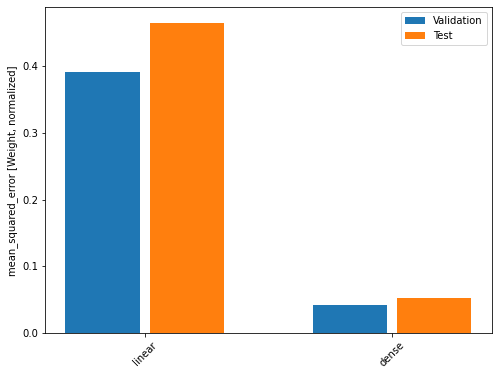

In [260]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_squared_error'
metric_index = dense.metrics_names.index('mean_squared_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_squared_error [Weight, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

## Generating predictions

We load the previously generated predictions

### Load data

In [261]:
input_predictions = pd.read_csv("../data/predictions.csv", usecols=train_in.reset_index().columns)
input_predictions = input_predictions.set_index(pd.to_datetime(input_predictions.crossTime))
input_predictions = input_predictions.drop(columns='crossTime')

# Normalize data
input_predictions = (input_predictions - train_in_mean) / train_in_std
input_predictions.head()

,speed,weight,n_vehicles,day_sin,day_cos,week_sin,week_cos,year_sin,year_cos
crossTime,,,,,,,,,
2018-10-21 23:00:00,-0.329648,-0.365480,-0.382088,0.029561,0.838816,-0.267357,-0.498864,-0.511952,0.314680
2018-10-22 00:00:00,-0.492578,-0.489207,-0.517491,0.106923,1.242422,-0.568714,-0.930049,-0.998304,0.473418
2018-10-22 01:00:00,-0.568568,-0.531221,-0.592715,0.343899,1.336201,-0.706476,-1.154634,-1.263125,0.566370
2018-10-22 02:00:00,-0.602230,-0.539888,-0.637850,0.661630,1.242406,-0.776313,-1.239733,-1.368033,0.607127
2018-10-22 03:00:00,-0.585776,-0.508984,-0.622805,0.988714,1.018947,-0.820206,-1.249196,-1.369280,0.616123


What our input prediction is trying to imitate

In [262]:
reference_in = test_in.loc[input_predictions.index]
reference_in.head()

,speed,weight,n_vehicles,day_sin,day_cos,week_sin,week_cos,year_sin,year_cos
crossTime,,,,,,,,,
2018-10-21 23:00:00,-0.639641,-0.627605,-0.637850,-3.660208e-01,1.366008,-0.566965,-1.295127,-1.300728,0.586817
2018-10-22 00:00:00,-0.609575,-0.592685,-0.607760,-6.557354e-12,1.414196,-0.615035,-1.273074,-1.300382,0.587780
2018-10-22 01:00:00,-0.637019,-0.604120,-0.637850,3.660208e-01,1.366008,-0.662246,-1.249239,-1.300035,0.588742
2018-10-22 02:00:00,-0.641738,-0.631270,-0.637850,7.070980e-01,1.224730,-0.708533,-1.223656,-1.299687,0.589705
2018-10-22 03:00:00,-0.533536,-0.514761,-0.532536,9.999875e-01,0.999988,-0.753831,-1.196359,-1.299339,0.590667


In [263]:
target = test_out.loc[predictions.index]
target.head()

nth_in_hour,1,2,3,4,5,6,7,8,9,10,...,387,388,389,390,391,392,393,394,395,396
2018-10-21 23:00:00,2.318901,3.649748,3.697335,-0.352526,-0.352526,-0.352526,-0.352526,-0.352526,-0.352526,-0.352526,...,-0.352526,-0.352526,-0.352526,-0.352526,-0.352526,-0.352526,-0.352526,-0.352526,-0.352526,-0.352526
2018-10-22 00:00:00,1.882135,2.373774,2.762327,2.833878,3.590378,-0.352526,-0.352526,-0.352526,-0.352526,-0.352526,...,-0.352526,-0.352526,-0.352526,-0.352526,-0.352526,-0.352526,-0.352526,-0.352526,-0.352526,-0.352526
2018-10-22 01:00:00,1.870182,2.982617,3.531520,-0.352526,-0.352526,-0.352526,-0.352526,-0.352526,-0.352526,-0.352526,...,-0.352526,-0.352526,-0.352526,-0.352526,-0.352526,-0.352526,-0.352526,-0.352526,-0.352526,-0.352526
2018-10-22 02:00:00,2.544314,3.130330,3.463384,-0.352526,-0.352526,-0.352526,-0.352526,-0.352526,-0.352526,-0.352526,...,-0.352526,-0.352526,-0.352526,-0.352526,-0.352526,-0.352526,-0.352526,-0.352526,-0.352526,-0.352526
2018-10-22 03:00:00,1.736300,2.008901,2.062238,2.448627,2.620875,3.045004,3.413064,3.431621,3.441355,3.634834,...,-0.352526,-0.352526,-0.352526,-0.352526,-0.352526,-0.352526,-0.352526,-0.352526,-0.352526,-0.352526


### Predictions and evaluation

Predict values

In [270]:
input_predictions_ds = tf.convert_to_tensor(input_predictions)

output_predictions_ds = dense(input_predictions_ds)
output_predictions = pd.DataFrame(output_predictions_ds.numpy(), index=input_predictions.index)

output_predictions.head()

,0,1,2,3,4,5,6,7,8,9,...,386,387,388,389,390,391,392,393,394,395
crossTime,,,,,,,,,,,,,,,,,,,,,
2018-10-21 23:00:00,2.021078,2.146678,2.210880,2.238194,2.158862,2.127743,2.093103,2.124083,2.262895,2.444766,...,-0.350617,-0.335273,-0.351466,-0.349935,-0.354324,-0.353400,-0.350195,-0.354368,-0.352090,-0.349167
2018-10-22 00:00:00,2.100248,2.291307,2.436543,2.599674,2.792187,2.955454,2.987833,2.892684,2.584146,2.064986,...,-0.351979,-0.344034,-0.353441,-0.351980,-0.355523,-0.354590,-0.352086,-0.355317,-0.351732,-0.352194
2018-10-22 01:00:00,2.482270,2.897463,3.110162,2.991440,2.502411,1.699382,0.896056,0.279330,-0.143097,-0.374784,...,-0.354937,-0.352462,-0.356150,-0.356644,-0.355456,-0.355385,-0.357006,-0.356700,-0.353357,-0.358317
2018-10-22 02:00:00,2.227055,2.446182,2.217301,1.536030,0.666536,-0.106379,-0.467706,-0.578948,-0.529481,-0.457510,...,-0.357776,-0.353039,-0.361905,-0.359101,-0.359029,-0.357959,-0.357806,-0.360388,-0.357769,-0.360867
2018-10-22 03:00:00,2.423953,2.787519,2.828527,2.407111,1.616739,0.670507,0.018532,-0.369348,-0.526653,-0.551461,...,-0.358221,-0.351939,-0.360319,-0.358839,-0.358767,-0.358952,-0.357152,-0.359769,-0.358607,-0.360419


Evaluate w.r.t test output

In [281]:
mse = np.mean((output_predictions.values - target.values)**2)
mae = np.mean(np.abs(output_predictions.values - target.values))

print(f"Mean squared error: {mse}")
print(f"Mean absolute error: {mae}")

Mean squared error: 0.5778711138737241
Mean absolute error: 0.22562702233561174


In [286]:
print(f"In seconds: rmse ~= {np.sqrt(mse) * train_out_std + train_out_mean:.4f}s")
print(f"In seconds: mae ~= {mae * train_out_std + train_out_mean:.4f}s")

In seconds: rmse ~= -0.4570s
In seconds: mae ~= -0.7179s


### Generating simulator data

In [287]:
generated_data = output_predictions * train_out_std + train_out_mean

In [298]:
has_car = generated_data.values >= 0
generated_data.where(has_car)

,0,1,2,3,4,5,6,7,8,9,...,386,387,388,389,390,391,392,393,394,395
crossTime,,,,,,,,,,,,,,,,,,,,,
2018-10-21 23:00:00,0.158303,0.219595,0.250925,0.264254,0.225541,0.210355,0.193451,0.208569,0.276308,0.365060,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-10-22 00:00:00,0.196937,0.290173,0.361047,0.440654,0.534599,0.614273,0.630073,0.583641,0.433077,0.179730,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-10-22 01:00:00,0.383362,0.585973,0.689769,0.631833,0.393190,0.001318,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-10-22 02:00:00,0.258818,0.365751,0.254059,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-10-22 03:00:00,0.354903,0.532322,0.552333,0.346685,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-10-20 18:00:00,0.084408,0.139777,0.192827,0.216324,0.197143,0.192098,0.181514,0.207875,0.272524,0.330348,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-10-20 19:00:00,0.093842,0.153685,0.195298,0.209552,0.179883,0.177043,0.187790,0.243437,0.333094,0.423930,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-10-20 20:00:00,0.112920,0.151100,0.189187,0.220403,0.277401,0.378530,0.489060,0.608757,0.699006,0.717600,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
generated_data.reset_index().melt(id_vars='crossTime')

In [1]:
# Kernel died, going to bed